In [1]:
%pip install scikit-learn nltk numpy pandas spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 259.2 kB/s eta 0:00:50
     --------------------------------------- 0.1/12.8 MB 465.5 kB/s eta 0:00:28
     --------------------------------------- 0.2/12.8 MB 913.1 kB/s eta 0:00:14
     - -------------------------------------- 0.3/12.8 MB 1.6 MB/s eta 0:00:08
     - -------------------------------------- 0.5/12.8 MB 2.1 MB/s eta 0:00:06
     -- ------------------------------------- 0.7/12.8 MB 2.6 MB/s eta 0:00:05
     -- ------------------------------------- 0.9/12.8 MB 2.7 MB/s eta 0:00:05
     --- ------------------------------------ 1.1/12.8 MB 2.9 MB/s eta 0:00:05

In [2]:
import numpy as np
import pandas as pd
import spacy
import nltk

from joblib import parallel_backend
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer
from numpy import ndarray
from pandas import DataFrame
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lesen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lesen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lesen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
output_path = 'OUTPUT/'
data_path = 'BUILD/'

In [5]:
train = pd.read_csv(f'{data_path}train.csv')
dev = pd.read_csv(f'{data_path}dev.csv')
#test = pd.read_csv(f'{data_path}test.csv')

In [6]:
def sentence_position(df: DataFrame):
    doc2nbsent = df.groupby('doc_id')['sentence_index'].max().to_dict()
    df['nb_sent'] = df['doc_id'].map(doc2nbsent.get)
    position = df['sentence_index'] / df['nb_sent']
    return position.values.reshape(-1, 1)

In [7]:
def is_verb(tag: str):
    return tag.startswith('VB') or tag == 'MD'

def verb_tense(sentence: str):
    verbs = [tag for _, tag in nltk.pos_tag(nltk.word_tokenize(sentence)) if is_verb(tag)]
    return '' if len(verbs) == 0 else verbs[0]

In [8]:
train['verb_tense'] = train['text'].map(verb_tense)
dev['verb_tense'] = dev['text'].map(verb_tense)
#test['verb_tense'] = test['text'].map(verb_tense)

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     -------------------------------------- 0.0/587.7 MB 682.7 kB/s eta 0:14:21
     -------------------------------------- 0.0/587.7 MB 393.8 kB/s eta 0:24:53
     -------------------------------------- 0.1/587.7 MB 563.7 kB/s eta 0:17:23
     ---------------------------------------- 0.3/587.7 MB 1.6 MB/s eta 0:06:13
     ---------------------------------------- 0.4/587.7 MB 2.1 MB/s eta 0:04:38
     ---------------------------------------- 0.7/587.7 MB 2.9 MB/s eta 0:03:24
     ---------------------------------------- 0.8/587.7 MB 2.8 MB/s eta 0:03:27
     ---------------------------------------- 1.0/587.7 MB 3.1 MB/s eta 0:03:11
     ---------------------------------------- 1.1/587.7 MB 3.3 MB/s eta 0:03:01
     ---------------------------------------- 1.3/587.7 MB 3.3 MB/s eta 0:02:57
     ---------------------------------------- 1.5

In [9]:
verb_tense_encoding = ['VB', 'VBC', 'VBD', 'VBF', 'VBG', 'VBN', 'VBP', 'VBZ', 'MD']

def verb_tense_encode(df: DataFrame):
    return np.asarray([[1 if verb_tense_encoding[i] == vt else 0 for i in range(len(verb_tense_encoding))] for vt in df['verb_tense']])

In [10]:
train['doc'] = np.asarray(nlp.pipe(train['text']))
dev['doc'] = np.asarray(nlp.pipe(dev['text']))
#test['doc'] = np.asarray(nlp.pipe(test['text']))

In [11]:
def entity_count(entity_type: str):
    return lambda df: np.asarray([[sum(1 for ent in doc.ents if ent.label_ == entity_type)] for doc in df['doc']])

In [12]:
def sentence_length(df: DataFrame):
    """Donne la longueur des phrases.

    Args:
        df (pd.DataFrame): Corpus
    """
    return df['text'].map(lambda x: len(x.split())).values.reshape(-1, 1)

In [13]:
def contains_ldots(sentence: str):
    return 1 if '...' in sentence else 0

In [14]:
train['contains_ldots'] = train['text'].map(contains_ldots)
dev['contains_ldots'] = dev['text'].map(contains_ldots)
#test['contains_ldots'] = test['text'].map(contains_ldots)

In [15]:
#stemmer = LancasterStemmer()
#stemmer = PorterStemmer()
#stemmer = SnowballStemmer(language='english')
stemmer = WordNetLemmatizer()

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: [stemmer.lemmatize(w) for w in analyzer(doc)]

In [16]:
class LemmatizedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        #return lambda doc: [w.text for w in doc]
        return lambda doc: [w.lemma_ for w in doc]

In [17]:
class PosTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: [w + '/' + tag for w, tag in nltk.pos_tag(analyzer(doc))]

In [18]:
classifier = make_pipeline(
    make_column_transformer(
        (
            TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=10),
            'text'
        ),
        #(
        #    StemmedTfidfVectorizer(
        #        stop_words='english',
        #        ngram_range=(1,3),
        #        min_df=10
        #    'text'
        #),
        (
            LemmatizedTfidfVectorizer(
                stop_words='english',
                ngram_range=(1,3),
                min_df=10
            ),
            'doc'
        ),
        #(
        #    PosTfidfVectorizer(
        #        stop_words='english',
        #        ngram_range=(1,3),
        #        min_df=10
        #    ),
        #    'text'
        #),
        #(
        #    'passthrough',
        #    ['sentence_index']
        #),
        #(
        #    'passthrough',
        #    ['contains_ldots']
        #),
        (
            FunctionTransformer(sentence_position),
            ['doc_id', 'sentence_index']
        ),
        #(
        #    FunctionTransformer(entity_count('LOC')),
        #    ['doc']
        #),
        (
            FunctionTransformer(entity_count('LAW')),
            ['doc']
        ),
        (
            FunctionTransformer(entity_count('DATE')),
            ['doc']
        ),
        #(
        #    FunctionTransformer(entity_count('PERSON')),
        #    ['doc']
        #),
        (
            FunctionTransformer(verb_tense_encode),
            ['verb_tense']
        ),
        #(
        #    FunctionTransformer(sentence_length),
        #    ['text']
        #),
    ),
    LogisticRegression(
        multi_class='multinomial',
        max_iter=10000
    )
)

In [19]:
with parallel_backend('threading', n_jobs=4):
    classifier.fit(train, train['labels'])

In [20]:
x = classifier.predict_proba(dev)

In [32]:
classifier.predict(dev)

array(['ANALYSIS', 'ANALYSIS', 'RPC', ..., 'RPC', 'NONE', 'RPC'],
      dtype=object)

In [22]:
train['pred'] = classifier.predict(train)
dev['pred'] = classifier.predict(dev)
#test['pred'] = classifier.predict(test)

In [23]:
def eval(df: DataFrame):
    ground_truth_labels = df['labels']
    submission_labels = df['pred']
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth_labels, submission_labels, average='weighted'
    )
    # https://pyformat.info/#number
    print(f'{precision:.3f} & {recall:.3f} & {f1:.3f}')

In [24]:
eval(train)

0.855 & 0.848 & 0.839


In [25]:
eval(dev)

0.715 & 0.701 & 0.672


''

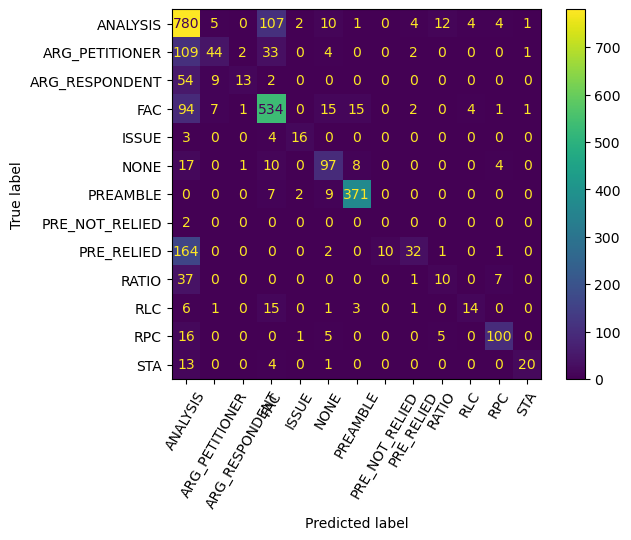

In [27]:
index2label: ndarray = classifier.named_steps['logisticregression'].classes_

confusion = confusion_matrix(dev['labels'], dev['pred'], labels=index2label)
confusion_plot = ConfusionMatrixDisplay(confusion, display_labels=index2label)
confusion_plot.plot(xticks_rotation=60)
_

In [28]:
dev

,doc_id,doc_index,sentence_index,annotation_id,text,meta_group,labels,verb_tense,doc,contains_ldots,pred
0,4115,222,52,40b9977a78e84f1da0fad3e939425b07,The Appellate Tribunal has referred to this de...,Tax,RATIO,VBZ,"(The, Appellate, Tribunal, has, referred, to, ...",0,ANALYSIS
1,4115,222,53,a850bcd509e542eba2b0111dac75dc91,"\n Similarly, in view of the orders of the Ass...",Tax,RATIO,VBZ,"(\n , Similarly, ,, in, view, of, the, orders,...",0,ANALYSIS
2,4115,222,54,436108c301e14169977c0fd46318c186,\n 12. In the light of the aforesaid discussio...,Tax,RPC,VBZ,"(\n , 12, ., In, the, light, of, the, aforesai...",0,RPC
3,4115,222,55,0cf6d5363ace43dab5493788c23f818b,No costs.,Tax,RPC,,"(No, costs, .)",0,RPC
4,4115,222,56,e952098ec3e948cc8cac6eb6513d7e8f,"13. In view of dismissal of the appeals, IA No...",Tax,RPC,VBZ,"(13, ., In, view, of, dismissal, of, the, appe...",0,RPC
...,...,...,...,...,...,...,...,...,...,...,...
2894,4090,246,117,d20ea0cee1e1491498f05197f9ef19e0,\n So Section 132 of the Evidence Act sufficie...,Criminal,RATIO,VBZ,"(\n , So, Section, 132, of, the, Evidence, Act...",0,ANALYSIS
2895,4090,246,118,1ec9d9a5c1a64a8bb423c5c8d6497892,"\n For the reasons aforesaid, the appeal is al...",Criminal,RPC,VBZ,"(\n , For, the, reasons, aforesaid, ,, the, ap...",0,RPC
2896,4090,246,119,d1f14db1ebff454ba2f13fdc90dc875f,"The judgment and order dated April 27, 1987 pa...",Criminal,RPC,VBN,"(The, judgment, and, order, dated, April, 27, ...",0,RPC
2897,4090,246,120,8adf1005d8c7458093a3f5599df282ca,\n R.S.S.,Criminal,NONE,,"(\n , R.S.S.)",0,NONE


In [31]:
dev[['annotation_id', 'pred']].rename(columns={'pred': 'labels'}).to_csv(f'{output_path}feature_based.csv', index=False)